In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
# from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.layers import Dense, LSTM, Input, Concatenate, BatchNormalization
from tensorflow.keras.layers import Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from google.colab import drive
import json
import shutil

# Mount Google Drive
drive.mount('/content/drive')

# Path folder di Google Drive untuk menyimpan model
drive_path = "/content/drive/My Drive/Colab Notebooks/Ekspor Models"

# Pastikan folder tujuan ada di Google Drive
import os
if not os.path.exists(drive_path):
    os.makedirs(drive_path)

!pip install --upgrade tensorflow

!python --version

print(f"Versi TensorFlow: {tf.__version__}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Python 3.10.12
Versi TensorFlow: 2.18.0



### 1. **Import Library**
```python
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Input, Concatenate, BatchNormalization
from tensorflow.keras.layers import Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from google.colab import drive
import json
import shutil
```

- **`pandas`**: Digunakan untuk membaca dan memproses data dalam format tabular seperti `.csv`.
- **`numpy`**: Digunakan untuk operasi matematika dan array numerik.
- **`sklearn.model_selection`**:
  - `train_test_split`: Untuk membagi dataset menjadi data latih dan validasi.
- **`sklearn.preprocessing`**:
  - `MinMaxScaler`: Normalisasi fitur ke rentang tertentu (0 hingga 1).
  - `LabelEncoder`: Mengubah label kategori menjadi angka.
- **`sklearn.metrics`**: Untuk menghitung metrik evaluasi model seperti akurasi dan error.
- **`compute_class_weight`**: Menghitung bobot kelas untuk menangani ketidakseimbangan data.
- **`tensorflow`**:
  - Framework untuk membangun model deep learning.
  - **`keras`** digunakan untuk membuat layer seperti `LSTM`, `Dense`, dan optimasi.
- **`seaborn`**: Untuk membuat visualisasi data.
- **`matplotlib.pyplot`**: Untuk membuat grafik dan plot.
- **`os`**: Mengelola sistem file seperti membuat folder.
- **`shutil`**: Memindahkan atau menyalin file.
- **`json`**: Membaca dan menulis data dalam format JSON.
- **`google.colab.drive`**: Menghubungkan Google Colab dengan Google Drive untuk menyimpan model.

---

### 2. **Mount Google Drive**
```python
drive.mount('/content/drive')
```
- Menghubungkan Google Colab dengan akun Google Drive pengguna. File dapat disimpan atau diakses dari Drive setelah ini.

---

### 3. **Path Folder di Google Drive**
```python
drive_path = "/content/drive/My Drive/Colab Notebooks/Ekspor Models"
```
- Menentukan lokasi penyimpanan file model atau hasil lainnya di Google Drive.

---

### 4. **Pastikan Folder Tujuan Ada**
```python
import os
if not os.path.exists(drive_path):
    os.makedirs(drive_path)
```
- Mengecek apakah folder tujuan (`drive_path`) sudah ada. Jika belum, membuat folder baru di lokasi tersebut.

---

### 5. **Install TensorFlow**
```python
!pip install --upgrade tensorflow
```
- Memastikan TensorFlow di Colab adalah versi terbaru dengan cara meng-upgrade library TensorFlow.

---

### 6. **Tampilkan Versi Python**
```python
!python --version
```
- Menampilkan versi Python yang sedang digunakan oleh Colab.

---

### 7. **Cek Versi TensorFlow**
```python
print(f"Versi TensorFlow: {tf.__version__}")
```
- Menampilkan versi TensorFlow yang saat ini diinstall. Penting untuk kompatibilitas kode dengan TensorFlow.

---

### **Penjelasan Kode Tambahan**
- **Menggunakan TensorFlow untuk Deep Learning**:
  - Layer seperti `LSTM` digunakan untuk analisis data sekuensial.
  - Layer `Dense` digunakan untuk membuat lapisan fully connected pada neural network.
  - Optimizers seperti `Adam` membantu meminimalkan fungsi loss selama pelatihan.

- **Mengelola Data dengan `pandas`**:
  - `pandas` digunakan untuk membaca dataset (`.csv`) dan memproses data untuk diinputkan ke dalam model.

- **Evaluasi Model**:
  - Menggunakan metrik seperti akurasi (`accuracy_score`) dan laporan klasifikasi (`classification_report`) untuk mengukur performa model.

---


In [5]:
# Path dataset
dataset_path_data_gizi_anak = "/content/drive/My Drive/Colab Notebooks/Datasets/gizi_anak_indonesia_balanced_1000.csv"
dataset_path_food_data = "/content/drive/My Drive/Colab Notebooks/Datasets/FOOD-DATA-GROUP5-CLEANED.csv"
# z_score_data_path = "/content/drive/My Drive/Colab Notebooks/Datasets/z_score_data_who.csv"

# Membaca dataset
growth_data = pd.read_csv(dataset_path_data_gizi_anak)
food_data = pd.read_csv(dataset_path_food_data)
# z_score_data = pd.read_csv(z_score_data_path)


---

### **1. Path Dataset**
```python
dataset_path_data_gizi_anak = "/content/drive/My Drive/Colab Notebooks/Datasets/gizi_anak_indonesia_balanced_1000.csv"
dataset_path_food_data = "/content/drive/My Drive/Colab Notebooks/Datasets/FOOD-DATA-GROUP5-CLEANED.csv"
# z_score_data_path = "/content/drive/My Drive/Colab Notebooks/Datasets/z_score_data_who.csv"
```

- **`dataset_path_data_gizi_anak`**:
  - Menyimpan path file dataset yang berisi data status gizi anak.
  - File `gizi_anak_indonesia_balanced_1000.csv` berisi informasi seperti usia, tinggi badan, berat badan, serta status gizi anak dalam format CSV (Comma-Separated Values).

- **`dataset_path_food_data`**:
  - Menyimpan path file dataset yang berisi data terkait makanan dan kandungan nutrisinya.
  - File `FOOD-DATA-GROUP5-CLEANED.csv` dapat digunakan untuk menganalisis rekomendasi makanan berdasarkan status gizi anak.

- **`z_score_data_path` (di-comment)**:
  - Path untuk dataset referensi WHO yang berisi data z-score untuk menganalisis pertumbuhan anak.
  - Data ini membantu menghitung status gizi anak dengan membandingkan BMI anak terhadap data referensi yang sesuai.

**Catatan**:
- Pastikan file pada path yang disebutkan telah diunggah ke Google Drive dengan struktur yang sama agar dapat diakses.

---

### **2. Membaca Dataset**
```python
growth_data = pd.read_csv(dataset_path_data_gizi_anak)
food_data = pd.read_csv(dataset_path_food_data)
z_score_data = pd.read_csv(z_score_data_path)
```

- **`pd.read_csv()`**:
  - Fungsi dari library `pandas` untuk membaca file CSV dan mengubahnya menjadi DataFrame, format yang mudah digunakan untuk analisis data.

1. **`growth_data`**:
   - Membaca dataset `gizi_anak_indonesia_balanced_1000.csv` ke dalam DataFrame `growth_data`.
   - Dataset ini berisi fitur-fitur seperti usia, tinggi badan, berat badan, dan status gizi anak.
   - Data ini digunakan sebagai input utama untuk membuat model prediksi status gizi anak.

2. **`food_data`**:
   - Membaca dataset `FOOD-DATA-GROUP5-CLEANED.csv` ke dalam DataFrame `food_data`.
   - Dataset ini berisi informasi makanan seperti nilai kalori, kandungan protein, lemak, vitamin, dan mineral.
   - Data ini biasanya digunakan untuk memberikan rekomendasi makanan berdasarkan status gizi anak.

3. **`z_score_data`**:
   - Membaca dataset `z_score_data_who.csv` ke dalam DataFrame `z_score_data`.
   - Dataset ini memuat data z-score referensi WHO, seperti BMI rata-rata (`Mean BMI`) dan standar deviasi (`SD BMI`) berdasarkan usia dan jenis kelamin anak.
   - Digunakan untuk menganalisis apakah BMI anak berada dalam kisaran yang sehat berdasarkan data standar WHO.

**Catatan**:
- Baris `z_score_data_path` masih di-comment sehingga dataset ini tidak akan dibaca sampai comment dihapus. Pastikan untuk menghapus `#` jika dataset tersebut dibutuhkan.

---

### **Cara Kerja Keseluruhan**
1. Path dataset didefinisikan terlebih dahulu, sehingga kode tahu lokasi file yang akan dibaca.
2. `pandas.read_csv()` digunakan untuk membaca file dari lokasi tersebut.
3. Data dari file CSV diubah menjadi DataFrame, yang memungkinkan manipulasi data seperti perhitungan, normalisasi, atau penghapusan nilai yang tidak diperlukan.

---

### **Kesalahan Umum**
1. **File Tidak Ditemukan**:
   - Pastikan file CSV ada di path yang telah disebutkan di Google Drive.
2. **Komentar pada `z_score_data_path`**:
   - Baris ini masih di-comment, sehingga jika ingin menggunakan `z_score_data`, comment harus dihapus.
3. **Format CSV Tidak Valid**:
   - Pastikan dataset berbentuk CSV dan memiliki format yang sesuai (header, delimiter, dll.).

---


In [6]:
growth_data.head()

,Usia (Tahun),Jenis Kelamin,Tinggi Badan (cm),Berat Badan (kg),BMI,Status Gizi,Kalori,Protein,Lemak,Karbohidrat,Vitamin C,Zat Besi,Kalsium,Riwayat Penyakit
0,11,Perempuan,144.7,25.2,15.13,Gizi Lebih,2395,70,17,114,71,17.82,1026,Diare
1,5,Laki-laki,133.4,34.4,17.54,Gizi Kurang,2416,10,27,139,143,16.37,1360,Stunting
2,17,Perempuan,140.0,27.6,25.68,Gizi Kurang,2838,46,12,151,113,12.38,649,Stunting
3,17,Perempuan,115.3,40.2,26.75,Gizi Lebih,1591,88,6,230,54,9.43,907,Diare
4,12,Laki-laki,115.0,37.1,17.83,Gizi Kurang,2539,67,58,116,116,5.56,1383,Infeksi Saluran Pernafasan


#### **Fungsi Utama**
Kode ini digunakan untuk menampilkan **5 baris pertama** dari dataset `growth_data`.

---

#### **Penjelasan Kode**
1. **`growth_data`**:
   - Adalah sebuah **DataFrame** yang sebelumnya dibaca dari file CSV menggunakan fungsi `pd.read_csv()`.
   - Dataset ini memuat informasi terkait status gizi anak, seperti:
     - Usia anak.
     - Tinggi badan.
     - Berat badan.
     - Status gizi (contohnya: "Gizi Kurang", "Gizi Baik", atau "Gizi Lebih").

2. **`.head()`**:
   - Adalah metode bawaan `pandas` yang digunakan untuk menampilkan beberapa baris pertama dari DataFrame.
   - Secara default, metode ini menampilkan **5 baris pertama**. Namun, Anda bisa menentukan jumlah baris yang ingin ditampilkan dengan menambahkan parameter, seperti `growth_data.head(10)` untuk 10 baris.

---

#### **Tujuan Penggunaan**
- **Memverifikasi Data**:
  - Memastikan dataset telah berhasil dimuat dengan benar ke dalam DataFrame.
  - Melihat struktur data, termasuk kolom-kolom yang tersedia dan beberapa nilai awal di dalamnya.

- **Mengidentifikasi Masalah**:
  - Melihat apakah ada nilai yang hilang (*missing values*), format data yang salah, atau inkonsistensi pada data.

In [7]:
food_data.head()

,food,caloric_value,fat,saturated_fats,monounsaturated_fats,polyunsaturated_fats,carbohydrates,sugars,protein,dietary_fiber,...,calcium,copper,iron,magnesium,manganese,phosphorus,potassium,selenium,zinc,nutrition_density
0,margarine with yoghurt,88,9.8,1.9,5.6,2.0,0.073,0.0,0.058,0.0,...,2.8,0.001,0.027,0.3,0.0,2.2,3.5,0.000,0.008,12.971
1,sunflower seed butter,99,8.8,0.7,6.2,1.6,3.700,1.7,2.800,0.9,...,10.2,0.300,0.700,49.8,0.3,106.6,92.2,0.075,0.800,27.500
2,hazelnut oil,120,13.6,1.0,10.6,1.4,0.000,0.0,0.000,0.0,...,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.000,0.000,13.600
3,menhaden fish oil,1966,218.0,66.3,58.2,74.5,0.000,0.0,0.000,0.0,...,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.000,0.000,218.000
4,cod liver fish oil,123,13.6,3.1,6.4,3.1,0.000,0.0,0.000,0.0,...,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.000,0.000,17.700


#### **Fungsi Utama**
Kode ini digunakan untuk menampilkan **5 baris pertama** dari dataset `food_data`.

---

#### **Penjelasan Kode**
1. **`food_data`**:
   - Adalah sebuah **DataFrame** yang sebelumnya dibaca dari file CSV menggunakan fungsi `pd.read_csv()`.
   - Dataset ini memuat informasi terkait kandungan dari suatu makanan atau minuman.

2. **`.head()`**:
   - Adalah metode bawaan `pandas` yang digunakan untuk menampilkan beberapa baris pertama dari DataFrame.
   - Secara default, metode ini menampilkan **5 baris pertama**. Namun, Anda bisa menentukan jumlah baris yang ingin ditampilkan dengan menambahkan parameter, seperti `food_data.head(10)` untuk 10 baris.

---

#### **Tujuan Penggunaan**
- **Memverifikasi Data**:
  - Memastikan dataset telah berhasil dimuat dengan benar ke dalam DataFrame.
  - Melihat struktur data, termasuk kolom-kolom yang tersedia dan beberapa nilai awal di dalamnya.

- **Mengidentifikasi Masalah**:
  - Melihat apakah ada nilai yang hilang (*missing values*), format data yang salah, atau inkonsistensi pada data.

In [8]:
print(growth_data['Status Gizi'].value_counts())

Status Gizi
Gizi Baik      334
Gizi Lebih     333
Gizi Kurang    333
Name: count, dtype: int64


---

#### **Fungsi Utama**
Kode ini digunakan untuk menghitung dan menampilkan jumlah kemunculan (*frekuensi*) setiap kategori dalam kolom **`Status Gizi`** pada dataset `growth_data`.

---

#### **Penjelasan Kode**
1. **`growth_data`**:
   - Merupakan sebuah **DataFrame** yang memuat data terkait status gizi anak.
   - DataFrame ini sebelumnya dibaca dari file CSV menggunakan `pd.read_csv()`.

2. **`growth_data['Status Gizi']`**:
   - Menunjuk ke kolom **`Status Gizi`** di dalam DataFrame `growth_data`.
   - Kolom ini berisi kategori status gizi anak, misalnya:
     - "Gizi Kurang".
     - "Gizi Baik".
     - "Gizi Lebih".

3. **`.value_counts()`**:
   - Fungsi bawaan `pandas` yang menghitung jumlah kemunculan unik dari setiap nilai/kategori dalam kolom `Status Gizi`.
   - Output berupa daftar kategori dengan jumlah frekuensi kemunculannya, diurutkan dari yang paling banyak hingga yang paling sedikit.

4. **`print()`**:
   - Digunakan untuk mencetak hasil dari `.value_counts()` ke layar.

---

#### **Tujuan Penggunaan**
- **Analisis Data Awal**:
  - Untuk mengetahui distribusi data pada kolom **`Status Gizi`**.
  - Memastikan apakah dataset memiliki distribusi data yang seimbang atau tidak, misalnya apakah jumlah data untuk kategori "Gizi Kurang", "Gizi Baik", dan "Gizi Lebih" cukup merata.

- **Identifikasi Masalah Dataset**:
  - Menemukan ketidakseimbangan (*class imbalance*), di mana jumlah data dalam satu kategori jauh lebih besar/kecil dibandingkan kategori lain.
  - Ketidakseimbangan ini penting diperhatikan karena dapat memengaruhi performa model prediksi.

---

In [9]:
# get data info
growth_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Usia (Tahun)       1000 non-null   int64  
 1   Jenis Kelamin      1000 non-null   object 
 2   Tinggi Badan (cm)  1000 non-null   float64
 3   Berat Badan (kg)   1000 non-null   float64
 4   BMI                1000 non-null   float64
 5   Status Gizi        1000 non-null   object 
 6   Kalori             1000 non-null   int64  
 7   Protein            1000 non-null   int64  
 8   Lemak              1000 non-null   int64  
 9   Karbohidrat        1000 non-null   int64  
 10  Vitamin C          1000 non-null   int64  
 11  Zat Besi           1000 non-null   float64
 12  Kalsium            1000 non-null   int64  
 13  Riwayat Penyakit   1000 non-null   object 
dtypes: float64(4), int64(7), object(3)
memory usage: 109.5+ KB


---

#### **Fungsi Utama**
Kode ini digunakan untuk menampilkan informasi ringkas tentang struktur dataset **`growth_data`**, termasuk tipe data, jumlah baris, kolom, nilai yang tidak kosong (*non-null*), dan ukuran memori yang digunakan.

---

#### **Penjelasan Kode**
1. **`growth_data`**:
   - **`growth_data`** adalah sebuah objek **DataFrame** yang berisi dataset terkait data pertumbuhan dan status gizi anak.
   - Objek ini dibuat sebelumnya menggunakan `pd.read_csv()` untuk membaca dataset dari file CSV.

2. **`.info()`**:
   - Fungsi bawaan `pandas` yang memberikan gambaran umum tentang DataFrame.
   - Informasi yang ditampilkan mencakup:
     - **Nama kolom**: Menunjukkan nama setiap kolom dalam dataset.
     - **Tipe data**: Menunjukkan tipe data setiap kolom, seperti integer (`int64`), float (`float64`), atau string (`object`).
     - **Jumlah nilai non-null**: Menampilkan jumlah nilai yang tidak kosong di setiap kolom.
     - **Jumlah total baris**: Menunjukkan jumlah baris dalam dataset.
     - **Penggunaan memori**: Menunjukkan jumlah memori yang digunakan oleh DataFrame.

3. **Hasil Fungsi**:
   - Hasil dari fungsi `.info()` dicetak langsung ke layar tanpa perlu menggunakan `print()`.

---

#### **Tujuan Penggunaan**
1. **Memahami Struktur Dataset**:
   - Untuk memahami jumlah baris dan kolom dalam dataset, serta mengetahui tipe data setiap kolom.

2. **Pengecekan Kualitas Data**:
   - Untuk memastikan tidak ada nilai yang hilang (*missing values*) pada dataset.
   - Jika terdapat nilai kosong di suatu kolom, jumlah nilai non-null akan lebih kecil dari total jumlah baris.

3. **Debugging Dataset**:
   - Untuk memeriksa apakah setiap kolom memiliki tipe data yang sesuai. Misalnya, kolom "Tinggi Badan" seharusnya memiliki tipe data numerik (bukan string).

---

In [10]:
# get data info
food_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 722 entries, 0 to 721
Data columns (total 35 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   food                  722 non-null    object 
 1   caloric_value         722 non-null    int64  
 2   fat                   722 non-null    float64
 3   saturated_fats        722 non-null    float64
 4   monounsaturated_fats  722 non-null    float64
 5   polyunsaturated_fats  722 non-null    float64
 6   carbohydrates         722 non-null    float64
 7   sugars                722 non-null    float64
 8   protein               722 non-null    float64
 9   dietary_fiber         722 non-null    float64
 10  cholesterol           722 non-null    float64
 11  sodium                722 non-null    float64
 12  water                 722 non-null    float64
 13  vitamin_a             722 non-null    float64
 14  vitamin_b1            722 non-null    float64
 15  vitamin_b11           7

---

#### **Fungsi Utama**
Kode ini digunakan untuk menampilkan informasi ringkas tentang struktur dataset **`food_data`**, termasuk tipe data, jumlah baris, kolom, nilai yang tidak kosong (*non-null*), dan ukuran memori yang digunakan.

---

#### **Penjelasan Kode**
1. **`food_data`**:
   - **`food_data`** adalah sebuah objek **DataFrame** yang berisi dataset terkait data kandungan pada makanan atau minuman.
   - Objek ini dibuat sebelumnya menggunakan `pd.read_csv()` untuk membaca dataset dari file CSV.

2. **`.info()`**:
   - Fungsi bawaan `pandas` yang memberikan gambaran umum tentang DataFrame.
   - Informasi yang ditampilkan mencakup:
     - **Nama kolom**: Menunjukkan nama setiap kolom dalam dataset.
     - **Tipe data**: Menunjukkan tipe data setiap kolom, seperti integer (`int64`), float (`float64`), atau string (`object`).
     - **Jumlah nilai non-null**: Menampilkan jumlah nilai yang tidak kosong di setiap kolom.
     - **Jumlah total baris**: Menunjukkan jumlah baris dalam dataset.
     - **Penggunaan memori**: Menunjukkan jumlah memori yang digunakan oleh DataFrame.

3. **Hasil Fungsi**:
   - Hasil dari fungsi `.info()` dicetak langsung ke layar tanpa perlu menggunakan `print()`.

---


In [11]:
growth_data.drop_duplicates(inplace=True)

---

#### **Fungsi Utama**
Kode ini digunakan untuk **menghapus baris duplikat** dari dataset **`growth_data`**, sehingga hanya menyisakan baris-baris yang unik.

---

#### **Penjelasan Kode**
1. **`growth_data`**:
   - Objek ini adalah **DataFrame** yang sebelumnya diisi dengan data dari dataset menggunakan fungsi `pd.read_csv()`.

2. **`drop_duplicates()`**:
   - Fungsi bawaan dari `pandas` untuk menghapus baris yang memiliki nilai duplikat di seluruh kolom dataset.
   - Baris dianggap duplikat jika semua nilai dalam baris tersebut identik dengan baris lain dalam dataset.

3. **`inplace=True`**:
   - Parameter ini memastikan bahwa perubahan dilakukan langsung pada **DataFrame asli** (`growth_data`), tanpa perlu membuat salinan baru.
   - Jika **`inplace=False`** (default), maka fungsi akan mengembalikan DataFrame baru tanpa duplikat, sementara DataFrame asli tetap tidak berubah.

---

#### **Tujuan Penggunaan**
1. **Meningkatkan Akurasi Analisis**:
   - Duplikat data dapat menyebabkan bias atau kesalahan dalam analisis, seperti perhitungan rata-rata, distribusi data, atau pelatihan model machine learning.
   - Dengan menghapus duplikat, dataset menjadi lebih bersih dan analisis menjadi lebih akurat.

2. **Mengurangi Ukuran Dataset**:
   - Dataset dengan duplikat data membutuhkan lebih banyak memori.
   - Menghapus duplikat dapat mengurangi ukuran dataset dan meningkatkan efisiensi pemrosesan.

3. **Menghindari Redundansi**:
   - Dalam analisis data atau pelatihan model, keberadaan duplikat bisa menyebabkan hasil yang tidak konsisten atau berulang.

---


In [12]:
food_data.drop_duplicates(inplace=True)

---

#### **Fungsi Utama**
Kode ini digunakan untuk **menghapus baris duplikat** dari dataset **`food_data`**, sehingga hanya menyisakan baris-baris yang unik.

---

#### **Penjelasan Kode**
1. **`food_data`**:
   - Objek ini adalah **DataFrame** yang sebelumnya diisi dengan data dari dataset menggunakan fungsi `pd.read_csv()`.

2. **`drop_duplicates()`**:
   - Fungsi bawaan dari `pandas` untuk menghapus baris yang memiliki nilai duplikat di seluruh kolom dataset.
   - Baris dianggap duplikat jika semua nilai dalam baris tersebut identik dengan baris lain dalam dataset.

3. **`inplace=True`**:
   - Parameter ini memastikan bahwa perubahan dilakukan langsung pada **DataFrame asli** (`food_data`), tanpa perlu membuat salinan baru.
   - Jika **`inplace=False`** (default), maka fungsi akan mengembalikan DataFrame baru tanpa duplikat, sementara DataFrame asli tetap tidak berubah.

---

#### **Tujuan Penggunaan**
1. **Meningkatkan Akurasi Analisis**:
   - Duplikat data dapat menyebabkan bias atau kesalahan dalam analisis, seperti perhitungan rata-rata, distribusi data, atau pelatihan model machine learning.
   - Dengan menghapus duplikat, dataset menjadi lebih bersih dan analisis menjadi lebih akurat.

2. **Mengurangi Ukuran Dataset**:
   - Dataset dengan duplikat data membutuhkan lebih banyak memori.
   - Menghapus duplikat dapat mengurangi ukuran dataset dan meningkatkan efisiensi pemrosesan.

3. **Menghindari Redundansi**:
   - Dalam analisis data atau pelatihan model, keberadaan duplikat bisa menyebabkan hasil yang tidak konsisten atau berulang.

---


In [13]:
# Hitung BMI
growth_data['BMI'] = growth_data['Berat Badan (kg)'] / ((growth_data['Tinggi Badan (cm)'] / 100) ** 2)

# Klasifikasi status gizi
def classify_nutrition(bmi):
    if bmi < 18.5:
        return "Gizi Kurang"
    elif 18.5 <= bmi < 25:
        return "Gizi Baik"
    else:
        return "Gizi Lebih"

growth_data['Status Gizi'] = growth_data['BMI'].apply(classify_nutrition)

# Encode status gizi
label_encoder = LabelEncoder()
growth_data['Status Gizi Encoded'] = label_encoder.fit_transform(growth_data['Status Gizi'])

# Normalisasi dan split data
scaler_X = MinMaxScaler()
X = growth_data[['Usia (Tahun)', 'Tinggi Badan (cm)', 'Berat Badan (kg)']].values
y = growth_data['Status Gizi Encoded'].values

X_scaled = scaler_X.fit_transform(X)
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Reshape data untuk LSTM
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val_lstm = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))


---

#### **1. Menghitung BMI**
```python
growth_data['BMI'] = growth_data['Berat Badan (kg)'] / ((growth_data['Tinggi Badan (cm)'] / 100) ** 2)
```

**Penjelasan:**
- **BMI (Body Mass Index)** adalah indikator umum yang digunakan untuk menilai status gizi seseorang.
- Formula:  
  \[
  \text{BMI} = \frac{\text{Berat Badan (kg)}}{\text{Tinggi Badan (m)}^2}
  \]
- Kolom **`BMI`** ditambahkan ke DataFrame **`growth_data`** dengan menghitung nilai BMI berdasarkan **Berat Badan (kg)** dan **Tinggi Badan (cm)**.  
  Tinggi badan diubah dari cm ke meter dengan membaginya dengan 100.

**Tujuan:**
Menggunakan nilai BMI untuk menentukan status gizi anak, seperti **Gizi Kurang**, **Gizi Baik**, atau **Gizi Lebih**.

---

#### **2. Klasifikasi Status Gizi**
```python
def classify_nutrition(bmi):
    if bmi < 18.5:
        return "Gizi Kurang"
    elif 18.5 <= bmi < 25:
        return "Gizi Baik"
    else:
        return "Gizi Lebih"

growth_data['Status Gizi'] = growth_data['BMI'].apply(classify_nutrition)
```

**Penjelasan:**
- **Fungsi `classify_nutrition(bmi)`**:
  - Klasifikasi status gizi berdasarkan nilai BMI:
    - **BMI < 18.5**: Anak dikategorikan sebagai **Gizi Kurang**.
    - **18.5 ≤ BMI < 25**: Anak dikategorikan sebagai **Gizi Baik**.
    - **BMI ≥ 25**: Anak dikategorikan sebagai **Gizi Lebih**.
- **`apply()`**:
  - Menerapkan fungsi **`classify_nutrition`** ke setiap baris pada kolom **`BMI`**.
- Kolom **`Status Gizi`** baru ditambahkan ke DataFrame untuk menyimpan hasil klasifikasi.

**Tujuan:**
Mengelompokkan anak berdasarkan status gizi mereka menggunakan nilai BMI.

---

#### **3. Encoding Status Gizi**
```python
label_encoder = LabelEncoder()
growth_data['Status Gizi Encoded'] = label_encoder.fit_transform(growth_data['Status Gizi'])
```

**Penjelasan:**
- **Label Encoding**:
  - Status gizi dalam bentuk kategori teks **("Gizi Kurang", "Gizi Baik", "Gizi Lebih")** dikonversi menjadi angka menggunakan **`LabelEncoder`**.
  - Hasil:
    - **"Gizi Kurang"** → 0
    - **"Gizi Baik"** → 1
    - **"Gizi Lebih"** → 2
- Kolom baru **`Status Gizi Encoded`** ditambahkan untuk menyimpan hasil encoding.

**Tujuan:**
Mempersiapkan data dalam bentuk numerik untuk digunakan dalam model machine learning.

---

#### **4. Normalisasi dan Pemisahan Data**
```python
scaler_X = MinMaxScaler()
X = growth_data[['Usia (Tahun)', 'Tinggi Badan (cm)', 'Berat Badan (kg)']].values
y = growth_data['Status Gizi Encoded'].values

X_scaled = scaler_X.fit_transform(X)
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
```

**Penjelasan:**
- **Fitur (X):**
  - Kolom input yang digunakan untuk prediksi:
    - **`Usia (Tahun)`**
    - **`Tinggi Badan (cm)`**
    - **`Berat Badan (kg)`**
- **Target (y):**
  - Kolom **`Status Gizi Encoded`** sebagai label atau target yang akan diprediksi.
- **Normalisasi (MinMaxScaler):**
  - **`MinMaxScaler`** digunakan untuk menskalakan nilai fitur **X** ke rentang antara **0 dan 1**.
  - Normalisasi membantu model machine learning bekerja lebih baik, terutama untuk model berbasis jaringan saraf.
- **Pemisahan Data:**
  - Dataset dibagi menjadi **data latih (80%)** dan **data validasi (20%)** menggunakan **`train_test_split`**.

**Tujuan:**
- **Normalisasi**: Mengurangi perbedaan skala antar fitur untuk membantu model belajar lebih baik.
- **Pemisahan Data**: Memastikan model diuji pada data yang belum pernah dilihat sebelumnya.

---

#### **5. Reshape Data untuk LSTM**
```python
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val_lstm = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
```

**Penjelasan:**
- Model **LSTM (Long Short-Term Memory)** mengharapkan data dalam bentuk **3 dimensi**:
  - **[samples, timesteps, features]**
  - Dalam kasus ini:
    - **samples**: Jumlah baris data.
    - **timesteps**: Jumlah langkah waktu. Di sini, hanya ada 1 langkah waktu.
    - **features**: Jumlah kolom input (3 fitur: usia, tinggi, berat).
- **`reshape()`**:
  - Mengubah data latih dan validasi agar sesuai dengan format input yang dibutuhkan oleh LSTM.

**Tujuan:**
Menyiapkan data dalam bentuk yang kompatibel dengan model LSTM.

---

#### **Kesimpulan**
Kode ini melakukan langkah-langkah berikut:
1. **Menghitung BMI**: Menggunakan berat badan dan tinggi badan untuk menghasilkan indikator status gizi.
2. **Mengklasifikasikan Status Gizi**: Menentukan kategori status gizi berdasarkan nilai BMI.
3. **Label Encoding**: Mengonversi status gizi menjadi angka untuk digunakan oleh model machine learning.
4. **Normalisasi**: Menskalakan data fitur ke rentang yang seragam untuk membantu model bekerja lebih baik.
5. **Pemisahan Data**: Membagi dataset menjadi data latih dan validasi untuk mengevaluasi performa model.
6. **Reshape Data**: Menyesuaikan format data agar sesuai dengan kebutuhan model LSTM.

In [14]:
# Membuat model prediksi status gizi
model_nutrition = Sequential([
    LSTM(50, activation='relu', input_shape=(1, X_train.shape[1])),
    Dense(16, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')
])

# Menambahkan `class_weight`
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y),
    y=y
)
class_weights = {i: weight for i, weight in enumerate(class_weights)}

# Kompilasi Model dengan `class_weight`
model_nutrition.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Melatih Model Prediksi Status Gizi
history_nutrition = model_nutrition.fit(
    X_train_lstm, y_train,
    validation_data=(X_val_lstm, y_val),
    epochs=100,
    batch_size=16,
    verbose=1,
    class_weight=class_weights
)

# Evaluasi model
nutrition_predictions = model_nutrition.predict(X_val_lstm)
nutrition_predictions_classes = np.argmax(nutrition_predictions, axis=1)
accuracy = accuracy_score(y_val, nutrition_predictions_classes)
print(f"Accuracy: {accuracy:.4f}")

# Classification report
report = classification_report(y_val, nutrition_predictions_classes, target_names=label_encoder.classes_)
print("Classification Report:")
print(report)

# Confusion Matrix
from sklearn.metrics import confusion_matrix
print("Confusion Matrix:")
print(confusion_matrix(y_val, nutrition_predictions_classes))


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5329 - loss: 1.0745 - val_accuracy: 0.6100 - val_loss: 1.0728
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5931 - loss: 1.0762 - val_accuracy: 0.5900 - val_loss: 1.0154
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7137 - loss: 0.9676 - val_accuracy: 0.6450 - val_loss: 0.9021
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7741 - loss: 0.8338 - val_accuracy: 0.8650 - val_loss: 0.6991
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8872 - loss: 0.6918 - val_accuracy: 0.9150 - val_loss: 0.5098
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9256 - loss: 0.5075 - val_accuracy: 0.9400 - val_loss: 0.3894
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9296 - loss: 0.3959 - val_accuracy: 0.9400 - val_loss: 0.3101
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9340 - loss: 0.3159 - val_accuracy: 0.9400 - val_loss: 0

---

#### **1. Membuat Model Prediksi Status Gizi**
```python
model_nutrition = Sequential([
    LSTM(50, activation='relu', input_shape=(1, X_train.shape[1])),
    Dense(16, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')
])
```

**Penjelasan:**
- **`Sequential`**:
  - Digunakan untuk membuat model neural network secara berurutan.
- **Layer LSTM**:
  - **`LSTM(50)`**: Layer Long Short-Term Memory dengan 50 unit neuron. LSTM digunakan untuk menangkap pola dalam data berurutan.
  - **`activation='relu'`**: Fungsi aktivasi ReLU (Rectified Linear Unit) digunakan untuk menambah non-linearitas.
  - **`input_shape=(1, X_train.shape[1])`**: Input data memiliki dimensi:
    - **1 timestep** (karena data direshape sebelumnya).
    - **X_train.shape[1]** (jumlah fitur, seperti usia, tinggi badan, berat badan).
- **Layer Dense**:
  - **`Dense(16)`**: Fully connected layer dengan 16 neuron dan aktivasi **ReLU**.
  - **`Dense(len(label_encoder.classes_), activation='softmax')`**:
    - Layer output untuk klasifikasi multi-kelas.
    - **`len(label_encoder.classes_)`** menentukan jumlah kelas (misalnya: Gizi Kurang, Gizi Baik, Gizi Lebih).
    - **`softmax`** digunakan untuk menghasilkan probabilitas kelas.

**Tujuan:**
Membangun model prediksi status gizi berbasis LSTM yang dapat menangkap pola hubungan antara usia, tinggi badan, dan berat badan.

---

#### **2. Menghitung Class Weight**
```python
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y),
    y=y
)
class_weights = {i: weight for i, weight in enumerate(class_weights)}
```

**Penjelasan:**
- **`compute_class_weight`**:
  - Digunakan untuk menangani ketidakseimbangan kelas dalam dataset.
  - **`class_weight='balanced'`**: Secara otomatis menghitung bobot untuk setiap kelas berdasarkan frekuensinya di dataset.
  - **`np.unique(y)`**: Mendapatkan daftar kelas unik dari data target **y**.
- **`class_weights`**:
  - Hasilnya adalah dictionary dengan format:
    - **Key**: Indeks kelas.
    - **Value**: Bobot kelas.
  - Contoh:
    ```python
    {0: 1.5, 1: 0.8, 2: 2.0}
    ```
  - Kelas dengan lebih sedikit sampel akan diberi bobot lebih tinggi.

**Tujuan:**
Memastikan model tidak bias terhadap kelas mayoritas dengan memberikan bobot lebih tinggi pada kelas minoritas.

---

#### **3. Kompilasi Model**
```python
model_nutrition.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
```

**Penjelasan:**
- **`optimizer='adam'`**:
  - Optimizer yang populer karena kecepatan konvergensi dan efektivitasnya dalam berbagai jenis data.
- **`loss='sparse_categorical_crossentropy'`**:
  - Fungsi loss untuk klasifikasi multi-kelas ketika label target berbentuk angka (bukan one-hot encoded).
- **`metrics=['accuracy']`**:
  - Menggunakan akurasi sebagai metrik evaluasi model selama pelatihan.

**Tujuan:**
Menyiapkan model untuk dilatih dengan pengaturan optimizer, fungsi loss, dan metrik evaluasi.

---

#### **4. Melatih Model**
```python
history_nutrition = model_nutrition.fit(
    X_train_lstm, y_train,
    validation_data=(X_val_lstm, y_val),
    epochs=100,
    batch_size=16,
    verbose=1,
    class_weight=class_weights
)
```

**Penjelasan:**
- **`X_train_lstm, y_train`**:
  - Data latih untuk melatih model.
- **`validation_data=(X_val_lstm, y_val)`**:
  - Data validasi untuk mengevaluasi performa model pada data yang tidak dilatih.
- **`epochs=100`**:
  - Jumlah iterasi penuh pada seluruh dataset selama pelatihan.
- **`batch_size=16`**:
  - Jumlah sampel yang diproses sekaligus sebelum memperbarui bobot model.
- **`class_weight=class_weights`**:
  - Menggunakan bobot kelas yang telah dihitung untuk menangani ketidakseimbangan kelas.
- **`verbose=1`**:
  - Menampilkan log pelatihan secara rinci.

**Tujuan:**
Melatih model pada data latih sambil memantau performanya pada data validasi.

---

#### **5. Evaluasi Model**
```python
nutrition_predictions = model_nutrition.predict(X_val_lstm)
nutrition_predictions_classes = np.argmax(nutrition_predictions, axis=1)
accuracy = accuracy_score(y_val, nutrition_predictions_classes)
print(f"Accuracy: {accuracy:.4f}")
```

**Penjelasan:**
- **`model_nutrition.predict(X_val_lstm)`**:
  - Menghasilkan probabilitas untuk setiap kelas berdasarkan data validasi.
- **`np.argmax(nutrition_predictions, axis=1)`**:
  - Mengambil indeks kelas dengan probabilitas tertinggi sebagai prediksi.
- **`accuracy_score(y_val, nutrition_predictions_classes)`**:
  - Membandingkan prediksi model dengan label aktual untuk menghitung akurasi.
- **`print()`**:
  - Menampilkan akurasi model.

**Tujuan:**
Mengevaluasi performa model menggunakan metrik akurasi.

---

#### **6. Classification Report**
```python
report = classification_report(y_val, nutrition_predictions_classes, target_names=label_encoder.classes_)
print("Classification Report:")
print(report)
```

**Penjelasan:**
- **`classification_report`**:
  - Menyediakan metrik evaluasi seperti precision, recall, f1-score, dan support untuk setiap kelas.
- **`target_names=label_encoder.classes_`**:
  - Memberikan nama kelas untuk interpretasi hasil.
- **`print()`**:
  - Menampilkan laporan klasifikasi.

**Tujuan:**
Menyediakan evaluasi mendetail untuk setiap kelas.

---

#### **7. Confusion Matrix**
```python
from sklearn.metrics import confusion_matrix
print("Confusion Matrix:")
print(confusion_matrix(y_val, nutrition_predictions_classes))
```

**Penjelasan:**
- **`confusion_matrix`**:
  - Menyediakan matriks yang menunjukkan jumlah prediksi benar dan salah untuk setiap kelas.
  - Format: Baris menunjukkan kelas aktual, kolom menunjukkan kelas yang diprediksi.
- **`print()`**:
  - Menampilkan matriks.

**Tujuan:**
Mengevaluasi distribusi kesalahan prediksi antar kelas.

---

#### **Kesimpulan**
Kode ini:
1. **Membangun model LSTM** untuk prediksi status gizi.
2. **Menangani ketidakseimbangan kelas** menggunakan bobot kelas.
3. **Melatih model** dengan data latih dan memantau performa pada data validasi.
4. **Mengevaluasi model** menggunakan akurasi, laporan klasifikasi, dan confusion matrix untuk menilai kinerjanya secara menyeluruh.

In [15]:
# Evaluasi model prediksi status gizi anak
nutrition_predictions = model_nutrition.predict(X_val_lstm)
nutrition_predictions_classes = np.argmax(nutrition_predictions, axis=1)

# Hitung akurasi
accuracy_nutrition = accuracy_score(y_val, nutrition_predictions_classes)
print(f"Akurasi Model Prediksi Status Gizi Anak: {accuracy_nutrition * 100:.2f}%")

# Classification report untuk metrik lebih detail
report_nutrition = classification_report(y_val, nutrition_predictions_classes, target_names=label_encoder.classes_)
print("Classification Report untuk Model Prediksi Status Gizi Anak:")
print(report_nutrition)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Akurasi Model Prediksi Status Gizi Anak: 97.50%
Classification Report untuk Model Prediksi Status Gizi Anak:
              precision    recall  f1-score   support

   Gizi Baik       0.89      1.00      0.94        42
 Gizi Kurang       1.00      0.97      0.98        65
  Gizi Lebih       1.00      0.97      0.98        93

    accuracy                           0.97       200
   macro avg       0.96      0.98      0.97       200
weighted avg       0.98      0.97      0.98       200



---

#### **1. Melakukan Prediksi pada Data Validasi**
```python
nutrition_predictions = model_nutrition.predict(X_val_lstm)
```

**Penjelasan:**
- **`model_nutrition.predict(X_val_lstm)`**:
  - Menggunakan model yang telah dilatih untuk membuat prediksi pada data validasi (**X_val_lstm**).
  - Model menghasilkan probabilitas untuk setiap kelas (misalnya: Gizi Kurang, Gizi Baik, Gizi Lebih) untuk setiap sampel di data validasi.
  - Output berupa array dua dimensi dengan ukuran `(jumlah_sampel, jumlah_kelas)`. Contoh:
    ```python
    [[0.1, 0.8, 0.1],  # Probabilitas untuk kelas 1 (Gizi Baik)
     [0.3, 0.4, 0.3],  # Probabilitas untuk kelas 1 (Gizi Baik)
     ...]
    ```

---

#### **2. Menentukan Kelas dengan Probabilitas Tertinggi**
```python
nutrition_predictions_classes = np.argmax(nutrition_predictions, axis=1)
```

**Penjelasan:**
- **`np.argmax(nutrition_predictions, axis=1)`**:
  - Mengambil indeks kelas dengan probabilitas tertinggi untuk setiap sampel.
  - **`axis=1`** berarti mencari probabilitas maksimum di sepanjang dimensi kolom (kelas).
  - Output berupa array satu dimensi berisi indeks kelas prediksi. Contoh:
    ```python
    [1, 1, 2, 0, ...]  # Indeks kelas prediksi untuk setiap sampel
    ```

---

#### **3. Menghitung Akurasi**
```python
accuracy_nutrition = accuracy_score(y_val, nutrition_predictions_classes)
print(f"Akurasi Model Prediksi Status Gizi Anak: {accuracy_nutrition * 100:.2f}%")
```

**Penjelasan:**
- **`accuracy_score(y_val, nutrition_predictions_classes)`**:
  - Membandingkan label sebenarnya (**y_val**) dengan prediksi model (**nutrition_predictions_classes**).
  - Menghitung proporsi prediksi yang benar terhadap seluruh prediksi.
- **`print(f"Akurasi Model Prediksi Status Gizi Anak: {accuracy_nutrition * 100:.2f}%")`**:
  - Menampilkan akurasi dalam format persentase dengan dua angka desimal.

---

#### **Kesimpulan**
Kode ini melakukan:
1. **Prediksi**: Menggunakan model untuk memprediksi status gizi pada data validasi.
2. **Evaluasi Akurasi**: Menghitung persentase prediksi benar.
3. **Analisis Mendetail**: Menggunakan laporan klasifikasi untuk menilai precision, recall, dan F1-score untuk setiap kelas, serta menampilkan distribusi prediksi benar dan salah menggunakan confusion matrix.

In [16]:
# Tampilkan summary model prediksi analisis gizi anak
print("\nSummary of Nutrition Analysis Model (LSTM):")
model_nutrition.summary()


Summary of Nutrition Analysis Model (LSTM):


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50)                  │          10,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │             816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 35,003 (136.73 KB)

 Trainable params: 11,667 (45.57 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 23,336 (91.16 KB)

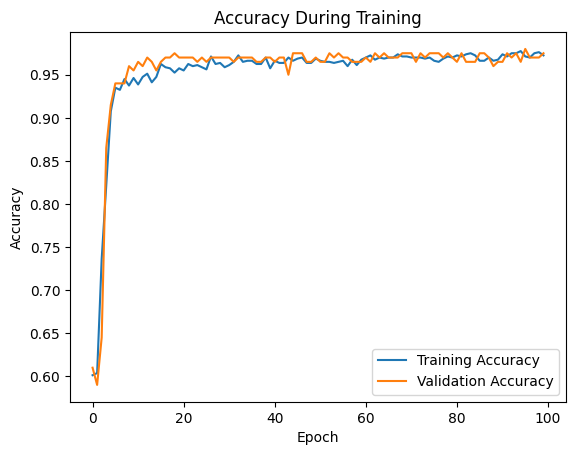

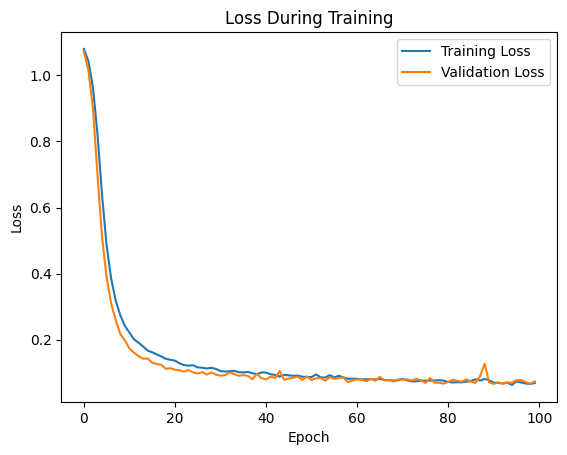

In [17]:
# Visualisasi Akurasi
plt.plot(history_nutrition.history['accuracy'], label='Training Accuracy')
plt.plot(history_nutrition.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy During Training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Visualisasi Loss
plt.plot(history_nutrition.history['loss'], label='Training Loss')
plt.plot(history_nutrition.history['val_loss'], label='Validation Loss')
plt.title('Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


---

### **Kode 1: Visualisasi Akurasi**
```python
plt.plot(history_nutrition.history['accuracy'], label='Training Accuracy')
plt.plot(history_nutrition.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy During Training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
```

#### Penjelasan:
1. **`plt.plot()`**:
   - Fungsi ini digunakan untuk membuat grafik.
   - **`history_nutrition.history['accuracy']`**:
     - Data akurasi model pada data **training** untuk setiap epoch selama proses pelatihan.
   - **`history_nutrition.history['val_accuracy']`**:
     - Data akurasi model pada data **validation** untuk setiap epoch selama proses pelatihan.

2. **`plt.title()`**:
   - Menambahkan judul pada grafik untuk memberikan konteks.
   - Dalam hal ini, judul grafik adalah **"Accuracy During Training"**.

3. **`plt.xlabel()`** dan **`plt.ylabel()`**:
   - Digunakan untuk menambahkan label pada sumbu **x** dan **y**:
     - **`Epoch`**: Sumbu **x** menunjukkan jumlah iterasi pelatihan.
     - **`Accuracy`**: Sumbu **y** menunjukkan tingkat akurasi model (dalam persentase).

4. **`plt.legend()`**:
   - Menambahkan legenda pada grafik untuk membedakan antara akurasi **training** dan **validation**.

5. **`plt.show()`**:
   - Menampilkan grafik ke layar.

#### Tujuan:
Grafik ini menunjukkan bagaimana akurasi model berkembang selama pelatihan pada data training dan validation. Idealnya:
- Akurasi **training** akan meningkat.
- Akurasi **validation** akan mengikuti pola akurasi training tanpa terlalu banyak perbedaan.

---

### **Kode 2: Visualisasi Loss**
```python
plt.plot(history_nutrition.history['loss'], label='Training Loss')
plt.plot(history_nutrition.history['val_loss'], label='Validation Loss')
plt.title('Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
```

#### Penjelasan:
1. **`plt.plot()`**:
   - Membuat grafik untuk loss selama pelatihan.
   - **`history_nutrition.history['loss']`**:
     - Data **loss** model pada data **training** selama pelatihan.
   - **`history_nutrition.history['val_loss']`**:
     - Data **loss** model pada data **validation** selama pelatihan.

2. **`plt.title()`**:
   - Menambahkan judul pada grafik, yaitu **"Loss During Training"**.

3. **`plt.xlabel()`** dan **`plt.ylabel()`**:
   - **`Epoch`**: Sumbu **x** menunjukkan jumlah iterasi pelatihan.
   - **`Loss`**: Sumbu **y** menunjukkan nilai loss, yaitu seberapa besar model membuat kesalahan dalam memprediksi.

4. **`plt.legend()`**:
   - Menambahkan legenda untuk membedakan antara loss **training** dan **validation**.

5. **`plt.show()`**:
   - Menampilkan grafik ke layar.

#### Tujuan:
Grafik ini menunjukkan perkembangan **loss** model selama pelatihan. Idealnya:
- Loss **training** dan **validation** akan menurun.
- Jika **loss validation** berhenti menurun atau meningkat sementara **loss training** terus menurun, ini bisa menjadi indikasi **overfitting**.

---

### **Kesimpulan**
Grafik akurasi dan loss adalah alat penting untuk memahami bagaimana model belajar selama pelatihan. Dengan memeriksa grafik ini, kita dapat:
1. Mengidentifikasi masalah seperti **overfitting** atau **underfitting**.
2. Memahami kapan proses pelatihan dapat dihentikan untuk menghindari pelatihan berlebih.

Hasil grafik akan memberikan gambaran visual tentang seberapa baik model Anda belajar dan bagaimana performa pada data yang tidak dilatih.

In [18]:
# **Prediksi dengan LSTM (Model Status Gizi Anak)**
nutrition_predictions = model_nutrition.predict(X_val_lstm)

# Konversi hasil prediksi menjadi label asli
nutrition_predictions_classes = np.argmax(nutrition_predictions, axis=1)
y_val_classes = y_val

# Tampilkan hasil prediksi untuk beberapa contoh
print("=== Contoh Prediksi Status Gizi ===")
# Sesuaikan jumlah iterasi dengan ukuran data validasi
for i in range(len(X_val)):  # Atau ganti len(X_val) dengan angka lebih kecil sesuai kebutuhan
    # Ambil data asli (usia, tinggi badan, berat badan) untuk true label
    usia = X_val[i][0] * (scaler_X.data_max_[0] - scaler_X.data_min_[0]) + scaler_X.data_min_[0]
    tinggi_badan = X_val[i][1] * (scaler_X.data_max_[1] - scaler_X.data_min_[1]) + scaler_X.data_min_[1]
    berat_badan = X_val[i][2] * (scaler_X.data_max_[2] - scaler_X.data_min_[2]) + scaler_X.data_min_[2]

    # Konversi prediksi ke format yang dapat dibaca
    predicted_label = label_encoder.inverse_transform([nutrition_predictions_classes[i]])[0]

    # Cetak hasil prediksi
    print(f"Contoh ke-{i+1}:")
    print(f"True Label (Actual Data): Usia: {usia:.1f} tahun, Tinggi: {tinggi_badan:.1f} cm, Berat: {berat_badan:.1f} kg")
    print(f"LSTM Prediction (Predicted Status): {predicted_label}")
    print()


# Evaluasi performa model
accuracy = accuracy_score(y_val_classes, nutrition_predictions_classes)
print("=== Evaluasi Performa Model ===")
print(f"Accuracy: {accuracy:.4f}")

# Tampilkan classification report untuk metrik lebih detail
report = classification_report(y_val_classes, nutrition_predictions_classes, target_names=label_encoder.classes_)
print("Classification Report:")
print(report)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
=== Contoh Prediksi Status Gizi ===
Contoh ke-1:
True Label (Actual Data): Usia: 7.0 tahun, Tinggi: 93.6 cm, Berat: 16.5 kg
LSTM Prediction (Predicted Status): Gizi Baik

Contoh ke-2:
True Label (Actual Data): Usia: 13.0 tahun, Tinggi: 161.0 cm, Berat: 23.3 kg
LSTM Prediction (Predicted Status): Gizi Kurang

Contoh ke-3:
True Label (Actual Data): Usia: 16.0 tahun, Tinggi: 111.8 cm, Berat: 67.5 kg
LSTM Prediction (Predicted Status): Gizi Lebih

Contoh ke-4:
True Label (Actual Data): Usia: 4.0 tahun, Tinggi: 130.4 cm, Berat: 50.9 kg
LSTM Prediction (Predicted Status): Gizi Lebih

Contoh ke-5:
True Label (Actual Data): Usia: 10.0 tahun, Tinggi: 188.7 cm, Berat: 27.2 kg
LSTM Prediction (Predicted Status): Gizi Kurang

Contoh ke-6:
True Label (Actual Data): Usia: 16.0 tahun, Tinggi: 105.3 cm, Berat: 24.7 kg
LSTM Prediction (Predicted Status): Gizi Baik

Contoh ke-7:
True Label (Actual Data): Usia: 11.0 tahun, Tinggi: 139.2 cm, Berat: 42.1 kg
LSTM Predic

---

### **1. Prediksi Status Gizi dengan Model LSTM**
```python
nutrition_predictions = model_nutrition.predict(X_val_lstm)
```

#### Penjelasan:
- **`model_nutrition.predict(X_val_lstm)`**:
  - Model LSTM menggunakan data validasi (**`X_val_lstm`**) untuk membuat prediksi.
  - Hasilnya adalah array 2D, di mana setiap baris mewakili prediksi probabilitas untuk setiap kelas status gizi.

---

### **2. Konversi Probabilitas menjadi Kelas**
```python
nutrition_predictions_classes = np.argmax(nutrition_predictions, axis=1)
y_val_classes = y_val
```

#### Penjelasan:
- **`np.argmax(nutrition_predictions, axis=1)`**:
  - Mengambil indeks kelas dengan probabilitas tertinggi (kelas yang diprediksi model) untuk setiap data validasi.
  - **`nutrition_predictions_classes`** adalah array 1D berisi kelas-kelas prediksi model.
- **`y_val_classes = y_val`**:
  - **`y_val`** adalah label kelas asli untuk data validasi.
  - **`y_val_classes`** menyimpan nilai label sebenarnya untuk evaluasi.

---

### **3. Menampilkan Contoh Prediksi**
```python
print("=== Contoh Prediksi Status Gizi ===")
for i in range(len(X_val)):
    usia = X_val[i][0] * (scaler_X.data_max_[0] - scaler_X.data_min_[0]) + scaler_X.data_min_[0]
    tinggi_badan = X_val[i][1] * (scaler_X.data_max_[1] - scaler_X.data_min_[1]) + scaler_X.data_min_[1]
    berat_badan = X_val[i][2] * (scaler_X.data_max_[2] - scaler_X.data_min_[2]) + scaler_X.data_min_[2]
    predicted_label = label_encoder.inverse_transform([nutrition_predictions_classes[i]])[0]
    print(f"Contoh ke-{i+1}:")
    print(f"True Label (Actual Data): Usia: {usia:.1f} tahun, Tinggi: {tinggi_badan:.1f} cm, Berat: {berat_badan:.1f} kg")
    print(f"LSTM Prediction (Predicted Status): {predicted_label}")
    print()
```

#### Penjelasan:
1. **`for i in range(len(X_val))`**:
   - Melakukan iterasi untuk setiap data validasi.
   - Menampilkan contoh prediksi status gizi.

2. **Dekode Fitur Input:**
   - **`usia`**, **`tinggi_badan`**, dan **`berat_badan`** dihitung dengan membalik normalisasi menggunakan **`scaler_X`**. Rumus:
     ```python
     original_value = scaled_value * (max_value - min_value) + min_value
     ```
   - Memberikan representasi asli dari fitur yang di-normalisasi.

3. **Dekode Kelas Prediksi:**
   - **`label_encoder.inverse_transform()`**:
     - Mengubah indeks kelas prediksi menjadi label asli (misalnya: "Gizi Baik", "Gizi Kurang").
   - **`predicted_label`** adalah status gizi yang diprediksi model.

4. **Cetak Hasil Prediksi:**
   - Menampilkan label asli (True Label) dan prediksi model untuk setiap data validasi.

---

### **4. Evaluasi Model**
```python
accuracy = accuracy_score(y_val_classes, nutrition_predictions_classes)
print("=== Evaluasi Performa Model ===")
print(f"Accuracy: {accuracy:.4f}")
```

#### Penjelasan:
1. **`accuracy_score()`**:
   - Menghitung persentase data validasi yang diprediksi dengan benar oleh model.
   - **`accuracy`** menyimpan nilai akurasi (dalam desimal, misalnya 0.90 = 90%).

2. **Cetak Hasil Akurasi:**
   - Menampilkan akurasi model pada data validasi dalam bentuk persentase.

---

### **5. Classification Report**
```python
report = classification_report(y_val_classes, nutrition_predictions_classes, target_names=label_encoder.classes_)
print("Classification Report:")
print(report)
```

#### Penjelasan:
1. **`classification_report()`**:
   - Menampilkan metrik evaluasi seperti:
     - **Precision**: Ketepatan model saat memprediksi suatu kelas.
     - **Recall**: Kemampuan model dalam menangkap semua data dari suatu kelas.
     - **F1-Score**: Kombinasi harmonis antara precision dan recall.
     - **Support**: Jumlah data sebenarnya untuk setiap kelas.

2. **`target_names=label_encoder.classes_`**:
   - Memberikan nama kelas asli pada laporan (misalnya: "Gizi Baik", "Gizi Kurang").

3. **Cetak Laporan:**
   - Menampilkan detail evaluasi performa model berdasarkan metrik-metrik di atas.

---

### **Ringkasan:**
Kode ini mencakup:
1. **Prediksi** status gizi anak menggunakan model LSTM.
2. **Dekode hasil prediksi** menjadi label yang mudah dipahami.
3. Menampilkan **contoh prediksi** untuk memberikan pemahaman visual.
4. Mengevaluasi model dengan metrik seperti:
   - Akurasi.
   - Classification Report.
5. Memberikan wawasan tentang performa model pada data validasi.

In [19]:
# **Fitur yang Digunakan**
# Pastikan fitur sesuai dengan dataset baru
food_features = [
    'caloric_value', 'fat', 'saturated_fats', 'monounsaturated_fats',
    'polyunsaturated_fats', 'carbohydrates', 'sugars', 'protein',
    'dietary_fiber', 'cholesterol', 'sodium', 'water', 'vitamin_a',
    'vitamin_b1', 'vitamin_b11', 'vitamin_b12', 'vitamin_b2', 'vitamin_b3',
    'vitamin_b5', 'vitamin_b6', 'vitamin_c', 'vitamin_d', 'vitamin_e',
    'vitamin_k', 'calcium', 'copper', 'iron', 'magnesium', 'manganese',
    'phosphorus', 'potassium', 'selenium', 'zinc', 'nutrition_density'
]

# **Normalisasi Data**
scaler_food = MinMaxScaler()
normalized_food_features = scaler_food.fit_transform(food_data[food_features])

---

### **1. Fitur yang Digunakan**
```python
food_features = [
    'caloric_value', 'fat', 'saturated_fats', 'monounsaturated_fats',
    'polyunsaturated_fats', 'carbohydrates', 'sugars', 'protein',
    'dietary_fiber', 'cholesterol', 'sodium', 'water', 'vitamin_a',
    'vitamin_b1', 'vitamin_b11', 'vitamin_b12', 'vitamin_b2', 'vitamin_b3',
    'vitamin_b5', 'vitamin_b6', 'vitamin_c', 'vitamin_d', 'vitamin_e',
    'vitamin_k', 'calcium', 'copper', 'iron', 'magnesium', 'manganese',
    'phosphorus', 'potassium', 'selenium', 'zinc', 'nutrition_density'
]
```

#### Penjelasan:
- **`food_features`**:
  - List ini berisi nama-nama kolom (fitur) yang akan digunakan dari dataset makanan (**`food_data`**).
  - Setiap fitur mewakili atribut nutrisi makanan, seperti:
    - **`caloric_value`**: Kandungan kalori dalam makanan.
    - **`fat`**, **`protein`**, **`carbohydrates`**: Makronutrien utama dalam makanan.
    - **Vitamin**: Berbagai vitamin (misalnya **`vitamin_a`**, **`vitamin_c`**).
    - **Mineral**: Mineral seperti **`calcium`**, **`iron`**, dan lainnya.
    - **`nutrition_density`**: Skor yang mencerminkan kepadatan nutrisi makanan.
  - Kolom-kolom ini diambil dari dataset untuk digunakan dalam analisis atau pelatihan model.

---

### **2. Normalisasi Data**
```python
scaler_food = MinMaxScaler()
normalized_food_features = scaler_food.fit_transform(food_data[food_features])
```

#### Penjelasan:
1. **`scaler_food = MinMaxScaler()`**:
   - Membuat objek scaler untuk normalisasi data.
   - **MinMaxScaler** adalah metode normalisasi yang mengubah nilai data menjadi rentang [0, 1].
   - Rumus normalisasi:
     \[
     X_{\text{normalized}} = \frac{X - X_{\text{min}}}{X_{\text{max}} - X_{\text{min}}}
     \]
   - **Tujuan Normalisasi**:
     - Menyamakan skala fitur-fitur agar model tidak memberikan bobot lebih pada fitur dengan nilai lebih besar.
     - Contoh: **`caloric_value`** yang memiliki nilai besar dibandingkan **`vitamin_b1`**.

2. **`scaler_food.fit_transform(food_data[food_features])`**:
   - **`food_data[food_features]`**:
     - Memilih kolom yang didefinisikan dalam **`food_features`** dari dataset makanan (**`food_data`**).
   - **`fit_transform`**:
     - **`fit`**: Menghitung nilai minimum dan maksimum untuk setiap kolom fitur dalam dataset.
     - **`transform`**: Menerapkan normalisasi ke dataset berdasarkan nilai minimum dan maksimum yang dihitung.

3. **`normalized_food_features`**:
   - Hasilnya adalah array 2D yang berisi nilai-nilai fitur yang telah dinormalisasi dalam rentang [0, 1].
   - Bentuk data ini siap digunakan untuk pelatihan model.

---

### **Kenapa Normalisasi Penting?**
1. **Menyamakan Skala Data**:
   - Fitur dengan skala besar (seperti **`caloric_value`**) tidak akan mendominasi fitur dengan skala kecil (seperti **`vitamin_b1`**).
   - Membantu algoritma pembelajaran mesin (seperti neural networks) untuk berfungsi lebih baik.

2. **Mempercepat Konvergensi Model**:
   - Normalisasi membantu model berbasis gradien, seperti neural networks, untuk mencapai solusi optimal lebih cepat.

3. **Meningkatkan Akurasi Model**:
   - Data yang terdistribusi dalam skala yang sama membuat model lebih akurat dan stabil.

---

### **Kesimpulan**:
Kode ini:
1. Memilih fitur nutrisi yang relevan dari dataset makanan (**`food_data`**).
2. Menerapkan normalisasi pada fitur-fitur tersebut untuk memastikan nilai-nilai mereka berada dalam rentang [0, 1].
3. Data yang telah dinormalisasi disimpan dalam **`normalized_food_features`**, yang siap digunakan untuk analisis lebih lanjut atau pelatihan model.

In [20]:
# **Model Rekomendasi**
# Input preferensi pengguna dan data makanan
user_input = Input(shape=(len(food_features),), name="user_input")
food_input = Input(shape=(len(food_features),), name="food_input")

# Arsitektur Model dengan Dropout dan LeakyReLU
concatenated = Concatenate()([user_input, food_input])

dense1 = Dense(512, activation='relu')(concatenated)
dense1 = BatchNormalization()(dense1)
dense1 = Dropout(0.3)(dense1)

dense2 = Dense(256, activation='relu')(dense1)
dense2 = BatchNormalization()(dense2)
dense2 = Dropout(0.2)(dense2)

dense3 = Dense(128, activation='relu')(dense2)
dense3 = BatchNormalization()(dense3)
dense3 = Dropout(0.2)(dense3)

output = Dense(1, activation='relu')(dense3)

recommendation_model = Model(inputs=[user_input, food_input], outputs=output)
recommendation_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=['mae', 'accuracy']
)

# **Generate Training Data**
# Membuat data preferensi pengguna dan rating acak
user_preferences = np.random.uniform(0, 1, size=(len(food_data), len(food_features)))
ratings = np.random.uniform(1, 5, size=(len(food_data), 1))

# Split data menjadi training dan validation
X_train_user, X_val_user, X_train_food, X_val_food, y_train_rec, y_val_rec = train_test_split(
    user_preferences, normalized_food_features, ratings, test_size=0.2, random_state=42
)

# # Callback Early Stopping untuk mencegah overfitting
# early_stopping = EarlyStopping(
#     monitor='mae',
#     patience=10,
#     restore_best_weights=True
# )

# **Train Model**
history_rec = recommendation_model.fit(
    [X_train_user, X_train_food], y_train_rec,
    validation_data=([X_val_user, X_val_food], y_val_rec),
    epochs=100,
    batch_size=32,
    verbose=1
    # callbacks=[early_stopping]
)

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.0000e+00 - loss: 7.7183 - mae: 2.4560 - val_accuracy: 0.0000e+00 - val_loss: 8.0499 - val_mae: 2.6019
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.0000e+00 - loss: 6.7775 - mae: 2.2177 - val_accuracy: 0.0000e+00 - val_loss: 5.3415 - val_mae: 2.0075
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.0000e+00 - loss: 5.3703 - mae: 1.9488 - val_accuracy: 0.0000e+00 - val_loss: 3.8124 - val_mae: 1.6301
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.0000e+00 - loss: 5.0504 - mae: 1.8849 - val_accuracy: 0.0000e+00 - val_loss: 2.5027 - val_mae: 1.3268
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0000e+00 - loss: 4.4445 - mae: 1.7105 - val_accuracy: 0.0000e+00 - val_loss: 1.8440 - val_mae: 1.1538
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.0000e+00 - loss: 4.1537 - mae: 1.6605 - val_accuracy: 0.0000e+00 - val_loss: 1.4749 - val_mae

---

### **1. Membuat Input untuk Model**
```python
user_input = Input(shape=(len(food_features),), name="user_input")
food_input = Input(shape=(len(food_features),), name="food_input")
```
#### Penjelasan:
- **`Input`**: Digunakan untuk mendefinisikan layer input pada model Keras.
- **Parameter**:
  - `shape=(len(food_features),)`: Menentukan dimensi input, yaitu panjang dari fitur makanan (**`food_features`**). Input ini berupa vektor dengan jumlah elemen sesuai jumlah fitur makanan.
  - `name`: Menentukan nama input. Dalam kasus ini:
    - **`user_input`**: Berisi preferensi pengguna terhadap fitur makanan.
    - **`food_input`**: Berisi data nutrisi makanan dari dataset.

---

### **2. Arsitektur Model Neural Network**
```python
concatenated = Concatenate()([user_input, food_input])
```
#### Penjelasan:
- **`Concatenate`**: Menggabungkan input pengguna (**`user_input`**) dan fitur makanan (**`food_input`**) menjadi satu vektor.
- **Tujuan**: Menggabungkan data preferensi pengguna dan data nutrisi makanan untuk diproses bersama oleh model.

---

#### Layer Hidden 1
```python
dense1 = Dense(512, activation='relu')(concatenated)
dense1 = BatchNormalization()(dense1)
dense1 = Dropout(0.3)(dense1)
```
- **`Dense(512, activation='relu')`**:
  - Layer dense (fully connected) dengan 512 neuron.
  - **`activation='relu'`**: Menggunakan fungsi aktivasi ReLU untuk mempercepat pelatihan dan menangani masalah non-linearitas.
- **`BatchNormalization()`**:
  - Menstabilkan distribusi input ke setiap layer selama pelatihan, mempercepat konvergensi, dan mencegah overfitting.
- **`Dropout(0.3)`**:
  - Menerapkan dropout sebesar 30%, yaitu secara acak menonaktifkan 30% neuron untuk mencegah overfitting.

---

#### Layer Hidden 2 dan 3
```python
dense2 = Dense(256, activation='relu')(dense1)
dense2 = BatchNormalization()(dense2)
dense2 = Dropout(0.2)(dense2)

dense3 = Dense(128, activation='relu')(dense2)
dense3 = BatchNormalization()(dense3)
dense3 = Dropout(0.2)(dense3)
```
- **Layer Hidden 2**:
  - **256 neuron**, fungsi aktivasi ReLU, batch normalization, dan dropout 20%.
- **Layer Hidden 3**:
  - **128 neuron**, fungsi aktivasi ReLU, batch normalization, dan dropout 20%.
- **Tujuan**: Memperdalam arsitektur model sehingga dapat menangkap hubungan kompleks antara data preferensi pengguna dan data makanan.

---

#### Layer Output
```python
output = Dense(1, activation='relu')(dense3)
```
- **`Dense(1, activation='relu')`**:
  - Layer terakhir dengan **1 neuron** untuk menghasilkan output berupa skor rekomendasi makanan.
  - Fungsi aktivasi ReLU digunakan karena output adalah nilai kontinu (regresi).

---

### **3. Membuat Model**
```python
recommendation_model = Model(inputs=[user_input, food_input], outputs=output)
```
#### Penjelasan:
- **`Model`**: Membuat model dengan input (preferensi pengguna dan data makanan) dan output (skor rekomendasi).
- **Tujuan**: Model ini digunakan untuk memberikan rekomendasi makanan berdasarkan preferensi pengguna dan nutrisi makanan.

---

### **4. Kompilasi Model**
```python
recommendation_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=['mae', 'accuracy']
)
```
#### Penjelasan:
- **`optimizer=Adam(learning_rate=0.001)`**:
  - Optimizer Adam digunakan untuk memperbarui bobot model secara adaptif.
  - **Learning rate = 0.001**: Menentukan kecepatan pembelajaran model.
- **`loss='mean_squared_error'`**:
  - Fungsi loss untuk regresi yang menghitung rata-rata kuadrat kesalahan antara nilai prediksi dan nilai sebenarnya.
- **`metrics=['mae', 'accuracy']`**:
  - **`mae`**: Mean Absolute Error, mengukur rata-rata kesalahan absolut.
  - **`accuracy`**: Akurasi model (hanya relevan jika klasifikasi digunakan).

---

### **5. Membuat Data Pelatihan**
```python
user_preferences = np.random.uniform(0, 1, size=(len(food_data), len(food_features)))
ratings = np.random.uniform(1, 5, size=(len(food_data), 1))
```
#### Penjelasan:
- **`user_preferences`**:
  - Data preferensi pengguna dihasilkan secara acak (nilai antara 0 dan 1) dengan dimensi yang sesuai dengan jumlah makanan dan fitur.
- **`ratings`**:
  - Data rating makanan dihasilkan secara acak (nilai antara 1 dan 5) untuk digunakan sebagai target (label).

---

### **6. Split Data**
```python
X_train_user, X_val_user, X_train_food, X_val_food, y_train_rec, y_val_rec = train_test_split(
    user_preferences, normalized_food_features, ratings, test_size=0.2, random_state=42
)
```
#### Penjelasan:
- **`train_test_split`**:
  - Membagi data menjadi **80% data pelatihan** dan **20% data validasi**.
- **Input**:
  - **`user_preferences`**: Preferensi pengguna.
  - **`normalized_food_features`**: Fitur nutrisi makanan.
  - **`ratings`**: Rating makanan.
- **Output**:
  - **Data Pelatihan**: `X_train_user`, `X_train_food`, `y_train_rec`.
  - **Data Validasi**: `X_val_user`, `X_val_food`, `y_val_rec`.

---

### **7. Melatih Model**
```python
history_rec = recommendation_model.fit(
    [X_train_user, X_train_food], y_train_rec,
    validation_data=([X_val_user, X_val_food], y_val_rec),
    epochs=100,
    batch_size=32,
    verbose=1
)
```
#### Penjelasan:
- **Parameter**:
  - **`[X_train_user, X_train_food], y_train_rec`**:
    - Input pelatihan (preferensi pengguna dan data makanan) dan target (rating makanan).
  - **`validation_data`**:
    - Data validasi untuk mengevaluasi performa model selama pelatihan.
  - **`epochs=100`**:
    - Jumlah iterasi pelatihan model melalui seluruh dataset.
  - **`batch_size=32`**:
    - Jumlah sampel yang diproses sekaligus dalam satu batch.
  - **`verbose=1`**:
    - Menampilkan log pelatihan.

- **`fit`**: Melatih model pada data pelatihan dan memvalidasinya menggunakan data validasi.

---

### **Kesimpulan**:
Kode ini membuat dan melatih model rekomendasi makanan berbasis neural network dengan:
1. **Input**: Preferensi pengguna dan nutrisi makanan.
2. **Output**: Skor rekomendasi makanan.
3. Model dirancang untuk menangani hubungan kompleks antara preferensi pengguna dan fitur makanan, dengan mengoptimalkan performa melalui batch normalization, dropout, dan fungsi aktivasi ReLU.

In [21]:
# Evaluasi model rekomendasi makanan
y_pred_rec = recommendation_model.predict([X_val_user, X_val_food]).flatten()

# Hitung Mean Squared Error (MSE) dan Mean Absolute Error (MAE)
mse_rec = mean_squared_error(y_val_rec, y_pred_rec)
mae_rec = mean_absolute_error(y_val_rec, y_pred_rec)

print(f"MSE Model Rekomendasi Makanan: {mse_rec:.4f}")
print(f"MAE Model Rekomendasi Makanan: {mae_rec:.4f}")

# Konversi MAE ke persen untuk interpretasi yang lebih mudah
mean_rating = np.mean(y_val_rec)
percentage_error = (mae_rec / mean_rating) * 100
print(f"Kesalahan Rata-rata Model Rekomendasi Makanan: {percentage_error:.2f}%")


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
MSE Model Rekomendasi Makanan: 1.7643
MAE Model Rekomendasi Makanan: 1.1148
Kesalahan Rata-rata Model Rekomendasi Makanan: 37.29%


---

- **MSE**:
  - Mengukur seberapa jauh prediksi model dari nilai sebenarnya (kuadrat kesalahan memperbesar pengaruh outlier).
- **MAE**:
  - Memberikan nilai rata-rata kesalahan dalam unit asli (lebih mudah diinterpretasikan).
- **Persentase Kesalahan**:
  - Menyediakan ukuran relatif dari performa model dibandingkan dengan skala data sebenarnya.

Evaluasi ini membantu dalam memahami kualitas prediksi model rekomendasi makanan dan menentukan apakah model sudah cukup baik atau perlu perbaikan.

In [22]:
# Tampilkan summary model prediksi analisis gizi anak
print("\nSummary of Nutrition Analysis Model (LSTM):")
recommendation_model.summary()


Summary of Nutrition Analysis Model (LSTM):


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ user_input (InputLayer)   │ (None, 34)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ food_input (InputLayer)   │ (None, 34)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 68)             │              0 │ user_input[0][0],      │
│                           │                        │                │ food_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 512)            │         35,328 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 512)            │          2,048 │ dense_2[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 512)            │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 256)            │        131,328 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256)            │          1,024 │ dense_3[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 256)            │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 128)            │         32,896 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128)            │            512 │ dense_4[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 128)            │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 1)              │            129 │ dropout_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 606,213 (2.31 MB)

 Trainable params: 201,473 (787.00 KB)

 Non-trainable params: 1,792 (7.00 KB)

 Optimizer params: 402,948 (1.54 MB)

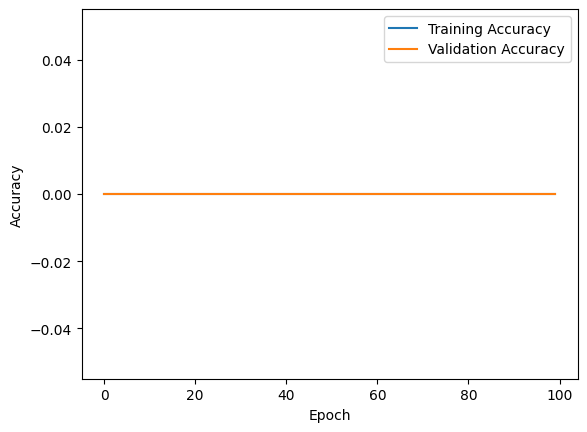

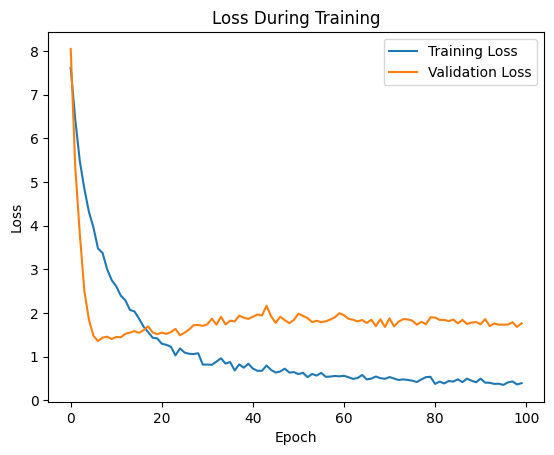

In [27]:
plt.plot(history_rec.history['accuracy'], label='Training Accuracy')
plt.plot(history_rec.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Visualisasi Loss
plt.plot(history_rec.history['loss'], label='Training Loss')
plt.plot(history_rec.history['val_loss'], label='Validation Loss')
plt.title('Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [24]:
# Simpan model
model_nutrition.save("model_nutrition_status.h5")
recommendation_model.save("recommendation_model.h5")

# Simpan scaler
scalers = {"scaler_X": scaler_X, "scaler_food": scaler_food}
with open("scalers.json", "w") as f:
    scalers_serializable = {key: scaler.__dict__.copy() for key, scaler in scalers.items()}
    for scaler_dict in scalers_serializable.values():
        for k, v in scaler_dict.items():
            if isinstance(v, np.ndarray):
                scaler_dict[k] = v.tolist()
    json.dump(scalers_serializable, f)

# Pindahkan file ke Google Drive
shutil.move("model_nutrition_status.h5", os.path.join(drive_path, "model_nutrition_status.h5"))
shutil.move("recommendation_model.h5", os.path.join(drive_path, "recommendation_model.h5"))
shutil.move("scalers.json", os.path.join(drive_path, "scalers.json"))

print(f"Models and scalers saved to Google Drive at {drive_path}")

Models and scalers saved to Google Drive at /content/drive/My Drive/Colab Notebooks/Ekspor Models


### **Tujuan Utama**
Kode ini bertujuan untuk:
1. **Menyimpan model machine learning** ke file (`.h5`).
2. **Menyimpan objek scaler** yang digunakan untuk normalisasi data ke file JSON.
3. **Memindahkan file hasil training ke Google Drive** agar mudah diakses atau digunakan di masa depan.

---

### **Penjelasan Baris Kode**
1. **Menyimpan model prediksi status gizi dan rekomendasi makanan:**
   ```python
   model_nutrition.save("model_nutrition_status.h5")
   recommendation_model.save("recommendation_model.h5")
   ```
   - **`model_nutrition.save()`**: Menyimpan model prediksi status gizi anak dalam format `.h5` (format file untuk model TensorFlow/Keras).
   - **`recommendation_model.save()`**: Menyimpan model rekomendasi makanan dalam format `.h5`.
   - **Tujuan**: File `.h5` ini dapat digunakan kembali untuk prediksi tanpa perlu melatih ulang model.

2. **Simpan scaler (normalizer):**
   ```python
   scalers = {"scaler_X": scaler_X, "scaler_food": scaler_food}
   with open("scalers.json", "w") as f:
       scalers_serializable = {key: scaler.__dict__.copy() for key, scaler in scalers.items()}
       for scaler_dict in scalers_serializable.values():
           for k, v in scaler_dict.items():
               if isinstance(v, np.ndarray):
                   scaler_dict[k] = v.tolist()
       json.dump(scalers_serializable, f)
   ```
   - **`scalers`**: Dictionary berisi dua scaler yang digunakan dalam proyek:
     - `scaler_X`: Untuk normalisasi data input pada model status gizi.
     - `scaler_food`: Untuk normalisasi fitur makanan pada model rekomendasi.
   - **`scaler.__dict__.copy()`**: Mengambil semua properti dari objek scaler untuk disimpan.
   - **`if isinstance(v, np.ndarray): v.tolist()`**: Karena JSON hanya mendukung tipe data Python bawaan, array NumPy (`np.ndarray`) harus dikonversi menjadi list Python (`tolist()`).
   - **`json.dump(scalers_serializable, f)`**: Menyimpan dictionary ke file JSON (`scalers.json`).
   - **Tujuan**: Agar scaler dapat digunakan kembali untuk preprocessing data di masa depan.

3. **Memindahkan file ke Google Drive:**
   ```python
   shutil.move("model_nutrition_status.h5", os.path.join(drive_path, "model_nutrition_status.h5"))
   shutil.move("recommendation_model.h5", os.path.join(drive_path, "recommendation_model.h5"))
   shutil.move("scalers.json", os.path.join(drive_path, "scalers.json"))
   ```
   - **`shutil.move()`**: Memindahkan file yang disimpan di direktori lokal ke Google Drive.
   - **`os.path.join(drive_path, ...)`**: Menentukan lokasi folder tujuan di Google Drive (`drive_path`) untuk setiap file:
     - `model_nutrition_status.h5`: Model prediksi status gizi.
     - `recommendation_model.h5`: Model rekomendasi makanan.
     - `scalers.json`: File JSON yang menyimpan objek scaler.
   - **Tujuan**: Agar file tersedia di Google Drive untuk akses mudah dan aman.

4. **Menampilkan pesan berhasil:**
   ```python
   print(f"Models and scalers saved to Google Drive at {drive_path}")
   ```
   - **Fungsi**: Memberikan konfirmasi kepada pengguna bahwa file model dan scaler telah berhasil dipindahkan ke Google Drive.

---

### **Kesimpulan**
Kode ini memastikan:
- **Model dan scaler tersimpan aman** di file dan bisa digunakan kembali tanpa pelatihan ulang.
- **Pemindahan ke Google Drive** memberikan aksesibilitas dan penyimpanan jangka panjang.


In [25]:
# import pandas as pd
# import os

# # Path ke dataset
# dataset_path_child_nutrition_data = "/content/drive/My Drive/Colab Notebooks/Datasets Food Nutrition/child_nutrition_data_200_items.csv"

# # Membaca semua file CSV di folder
# csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

# # List untuk menyimpan data dari setiap file
# dataframes = []

# # Membaca dan menambahkan isi file CSV ke dalam list
# for file in csv_files:
#     file_path = os.path.join(folder_path, file)
#     df = pd.read_csv(file_path)  # Membaca CSV
#     dataframes.append(df)  # Menambahkan DataFrame ke dalam list

# # Menggabungkan semua DataFrame
# combined_df = pd.concat(dataframes, ignore_index=True)

# # Menyimpan hasil ke file baru
# combined_df.to_csv("combined_output.csv", index=False)

# print("Semua file CSV berhasil digabungkan ke 'combined_output.csv'")
